# Race Condition Replay


This python deals with analyzing a real-time stream processing system for a high-frequency trading platform where rare race conditions are introducing silent duplicates in the output.

## Assumptions 

> **Timestamps Are Trustworthy for Sequencing:**
   We assume all `start_time`, `end_time`, and `timestamp` fields are accurate and can reliably be used to trace event flow and identify overlaps or retries.
> **Worker Logs Reflect True Processing:**
   The `worker_logs.csv` is assumed to provide a complete and accurate record of all event processing attempts, including failures and retries.

## Importing the Libraries

In [ ]:
import json
import pandas as pd
from pandas import to_datetime
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors



## Reading Files

In [169]:
df = pd.read_csv('03_worker_logs.csv')
worker_logs_df = pd.read_csv('03_worker_logs.csv')
final_output_df = pd.read_csv('04_final_output.csv')
with open('02_raw_tick_events.log', 'r') as f:
    raw_tick_events = [json.loads(line) for line in f]

print(raw_tick_events[:5])  # print first 5 events for inspection


[{'event_id': 'evt_0000000', 'timestamp': '2025-07-12T09:15:00Z', 'symbol': 'SBIN', 'price': 1222.66, 'source': 'stream-1'}, {'event_id': 'evt_0000001', 'timestamp': '2025-07-12T09:15:00.005000Z', 'symbol': 'SBIN', 'price': 1550.06, 'source': 'stream-1'}, {'event_id': 'evt_0000002', 'timestamp': '2025-07-12T09:15:00.010000Z', 'symbol': 'TCS', 'price': 1279.08, 'source': 'stream-1'}, {'event_id': 'evt_0000003', 'timestamp': '2025-07-12T09:15:00.015000Z', 'symbol': 'RELIANCE', 'price': 2353.4, 'source': 'stream-1'}, {'event_id': 'evt_0000004', 'timestamp': '2025-07-12T09:15:00.020000Z', 'symbol': 'ITC', 'price': 1173.88, 'source': 'stream-1'}]


## Having a Look at the Given Dataset (Understanding what we have at Hand)

In [170]:
# saving the original dataframe for use later
original_df = df.copy()
df.head()

,event_id,worker_id,start_time,end_time,status
0,evt_0000000,worker-2,2025-07-12T09:15:00,2025-07-12T09:15:00.005000,success
1,evt_0000001,worker-1,2025-07-12T09:15:00.005000,2025-07-12T09:15:00.012000,success
2,evt_0000002,worker-3,2025-07-12T09:15:00.010000,2025-07-12T09:15:00.022000,success
3,evt_0000003,worker-1,2025-07-12T09:15:00.015000,2025-07-12T09:15:00.026000,success
4,evt_0000004,worker-3,2025-07-12T09:15:00.020000,2025-07-12T09:15:00.023000,success


In [171]:
# sorted dataframe based on the satrt time
sorted_df = df.sort_values(by=['start_time'])

# the first 1000 events are sampled out of the sorted dataframe to be able to easily visualise or understand the daya 
sampled_df = sorted_df.head(5)
df = sampled_df.copy()
df.head()

,event_id,worker_id,start_time,end_time,status
0,evt_0000000,worker-2,2025-07-12T09:15:00,2025-07-12T09:15:00.005000,success
1,evt_0000001,worker-1,2025-07-12T09:15:00.005000,2025-07-12T09:15:00.012000,success
2,evt_0000002,worker-3,2025-07-12T09:15:00.010000,2025-07-12T09:15:00.022000,success
3,evt_0000003,worker-1,2025-07-12T09:15:00.015000,2025-07-12T09:15:00.026000,success
4,evt_0000004,worker-3,2025-07-12T09:15:00.020000,2025-07-12T09:15:00.023000,success


In [172]:
# understanding the raw tick events data
raw_tick_events_df = pd.DataFrame(raw_tick_events)
raw_tick_events_df.head()


,event_id,timestamp,symbol,price,source
0,evt_0000000,2025-07-12T09:15:00Z,SBIN,1222.66,stream-1
1,evt_0000001,2025-07-12T09:15:00.005000Z,SBIN,1550.06,stream-1
2,evt_0000002,2025-07-12T09:15:00.010000Z,TCS,1279.08,stream-1
3,evt_0000003,2025-07-12T09:15:00.015000Z,RELIANCE,2353.40,stream-1
4,evt_0000004,2025-07-12T09:15:00.020000Z,ITC,1173.88,stream-1


## Graph to visualise the sample data

In [ ]:
combined_ticks_worker_df = pd.merge(raw_tick_events_df, worker_logs_df, on='event_id', how='inner')

combined_ticks_worker_df = combined_ticks_worker_df[
    combined_ticks_worker_df['event_id'].between('evt_0003200', 'evt_0003300')
]
dd = combined_ticks_worker_df.copy()
combined_ticks_worker_df['timestamp'] = pd.to_datetime(
    combined_ticks_worker_df['timestamp'], 
    format='%Y-%m-%dT%H:%M:%S.%fZ', 
    errors='coerce'
)

# Fallback for those without fractional seconds
mask = combined_ticks_worker_df['timestamp'].isna()
combined_ticks_worker_df.loc[mask, 'timestamp'] = pd.to_datetime(
    dd.loc[mask, 'timestamp'], 
    format='%Y-%m-%dT%H:%M:%SZ', 
    errors='coerce'
)

combined_ticks_worker_df['start_time'] = pd.to_datetime(
    combined_ticks_worker_df['start_time'],
    format='%Y-%m-%dT%H:%M:%S.%f',
    errors='coerce'
)

mask = combined_ticks_worker_df['start_time'].isna()
combined_ticks_worker_df.loc[mask, 'start_time'] = pd.to_datetime(
    dd.loc[mask, 'start_time'],
    format='%Y-%m-%dT%H:%M:%S',
    errors='coerce'
)


combined_ticks_worker_df['end_time'] = pd.to_datetime(
    dd['end_time'],
    format='%Y-%m-%dT%H:%M:%S.%f',
    errors='coerce'
)
mask = combined_ticks_worker_df['end_time'].isna()
combined_ticks_worker_df.loc[mask, 'end_time'] = pd.to_datetime(
    dd.loc[mask, 'end_time'],
    format='%Y-%m-%dT%H:%M:%S',
    errors='coerce'
)


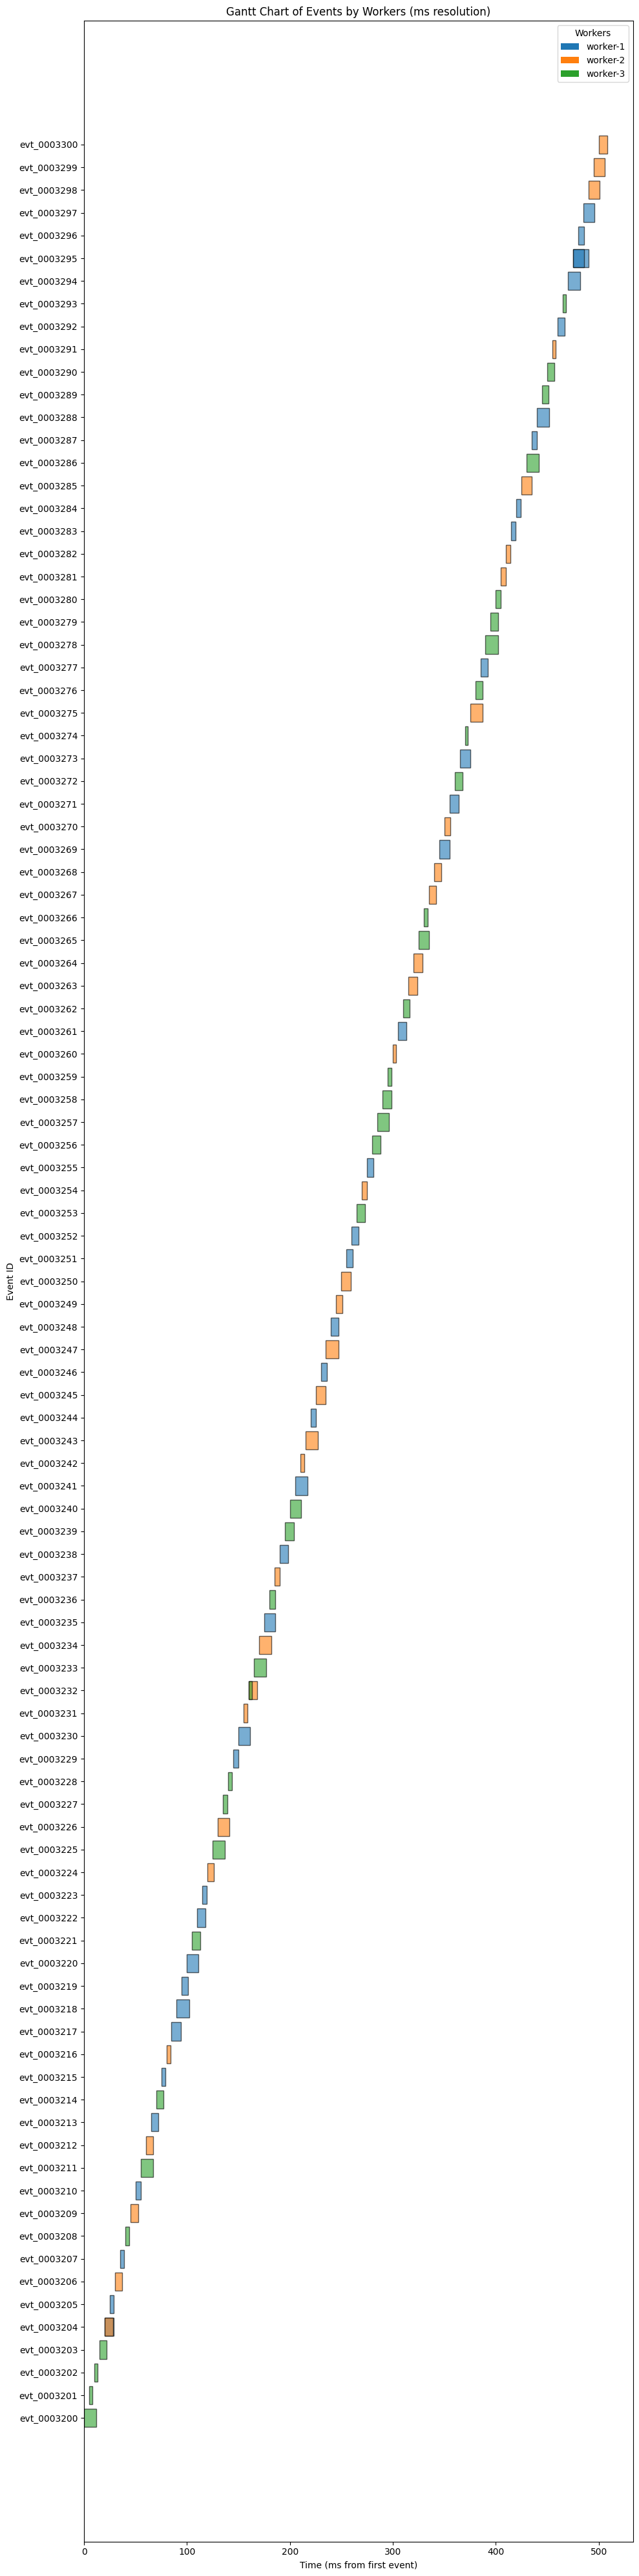

In [ ]:
# setting up the dataframe for visualization
df = pd.DataFrame(combined_ticks_worker_df)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Ensure 'start_time' and 'end_time' are in datetime format
t0 = df['start_time'].min()
df['start_ms'] = (df['start_time'] - t0).dt.total_seconds() * 1000  # convert to ms
df['duration_ms'] = (df['end_time'] - df['start_time']).dt.total_seconds() * 1000  # convert to ms

colors = {
    'worker-1': 'tab:blue',
    'worker-2': 'tab:orange',
    'worker-3': 'tab:green'
}

# Subplots
fig, ax = plt.subplots(figsize=(10, 40))

for i, row in df.iterrows():
    ax.barh(
        y=str(row['event_id']),
        width=row['duration_ms'],
        left=row['start_ms'],
        color=colors.get(row['worker_id'], 'gray'),
        edgecolor='black',
        alpha=0.6  
    )

# Formatting the lables of the axes
ax.set_xlabel('Time (ms from first event)')
ax.set_ylabel('Event ID')
ax.set_title('Gantt Chart of Events by Workers (ms resolution)')


# Legend
legend_elements = [Patch(facecolor=color, label=worker) for worker, color in colors.items()]
ax.legend(handles=legend_elements, title="Workers")

plt.tight_layout()
plt.show()


#### Observations:

This graph helps us to understand how the intersecting events work these graphs are meant to simplify the analysis of the data that is given to us and understand the things given to us

> This graph that was initially made only for a 100 people shows us a lot.
> We can clearly in how some places there are 2 or more workers doing the same task as in events evt_30003204, evt_30003242, and also in one case we have seen that there is a same worker doing the same task twice, evt_0003295 

# TimeLine Visualisations

Worker: worker-3
Worker: worker-1
Worker: worker-2


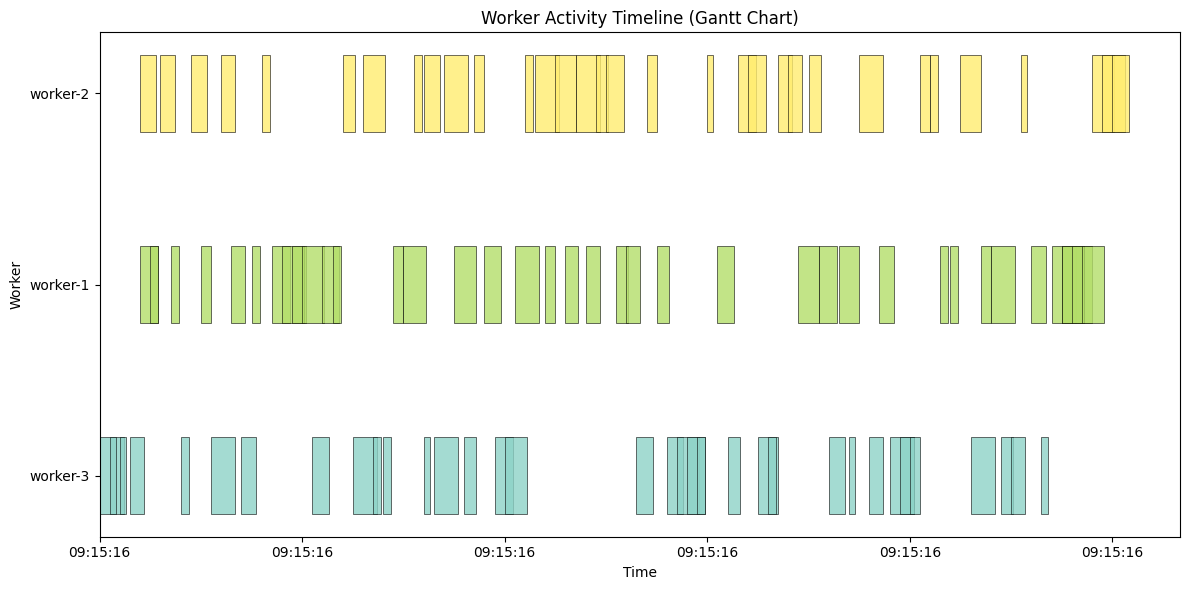

Overlapping windows found: 0
Retried jobs found: 250
Failed events found: 100


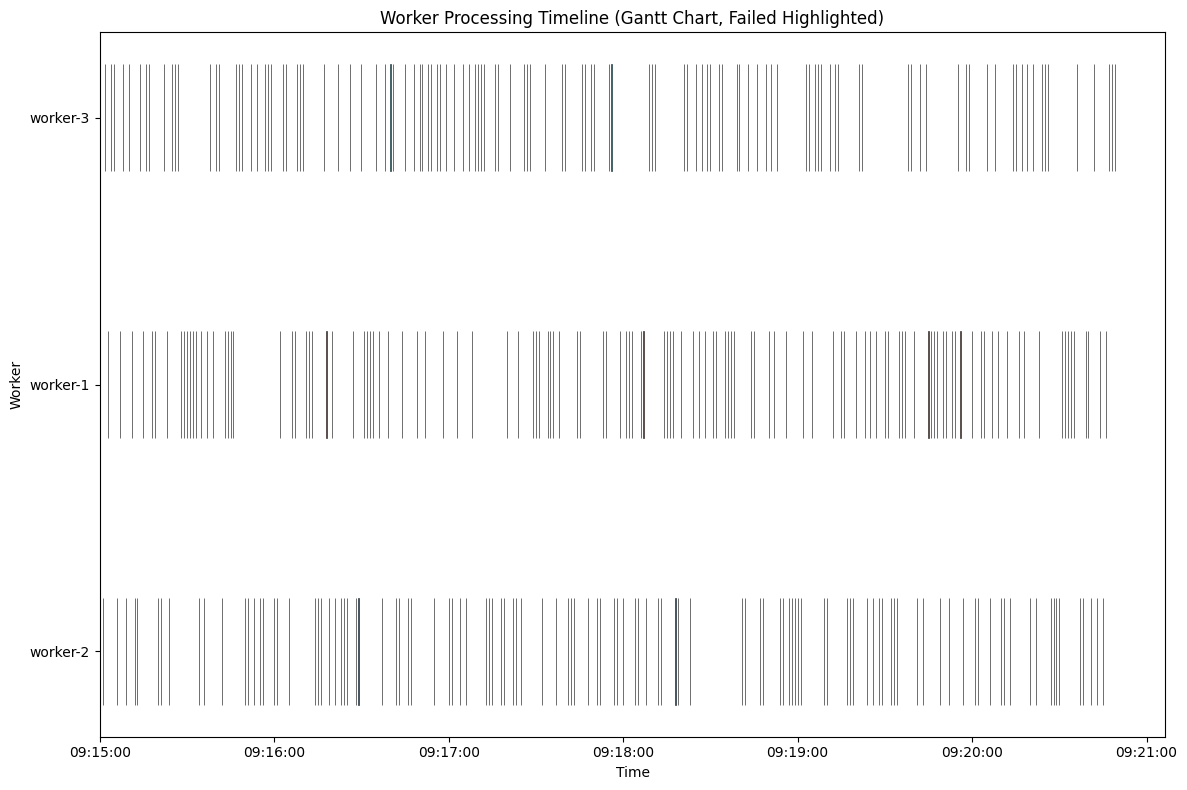

In [187]:
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S')
df['end_time'] = pd.to_datetime(df['end_time'], format='%Y-%m-%dT%H:%M:%S')

# Preparing the data for Gantt chart
workers = df['worker_id'].unique()
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set3(np.linspace(0, 1, len(workers)))  # Using Set3 colormap for distinct colors
worker_colors = dict(zip(workers, colors))

for i, worker in enumerate(workers):
    print(f"Worker: {worker}")
    worker_df = df[df['worker_id'] == worker]
    ax.barh(
        y=worker,
        left=worker_df['start_time'],
        width=(worker_df['end_time'] - worker_df['start_time']),
        height=0.4,
        color=worker_colors[worker],
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5,
        label=worker
    )

ax.set_xlabel('Time')
ax.set_ylabel('Worker')
ax.set_title('Worker Activity Timeline (Gantt Chart)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.tight_layout()
plt.show()

# Parsing worker_logs_df for timeline analysis
worker_logs_df['start_time'] = pd.to_datetime(worker_logs_df['start_time'], errors='coerce')
worker_logs_df['end_time'] = pd.to_datetime(worker_logs_df['end_time'], errors='coerce')

# Overlapping windows: Find events with overlapping times for the same worker 
overlaps = []
for worker in worker_logs_df['worker_id'].unique():
    wdf = worker_logs_df[worker_logs_df['worker_id'] == worker]
    wdf = wdf.dropna(subset=['start_time', 'end_time'])  # Remove rows with null times
    
    for i in range(len(wdf)):
        for j in range(i+1, len(wdf)):
            event1 = wdf.iloc[i]
            event2 = wdf.iloc[j]
            
            # Check if events overlap: start1 < end2 AND start2 < end1
            if (event1['start_time'] < event2['end_time'] and 
                event2['start_time'] < event1['end_time']):
                
                # Calculate overlap duration for additional info
                overlap_start = max(event1['start_time'], event2['start_time'])
                overlap_end = min(event1['end_time'], event2['end_time'])
                overlap_duration = (overlap_end - overlap_start).total_seconds()
                
                overlaps.append((worker, event1['event_id'], event2['event_id'], overlap_duration))

# Retried jobs: Events with same event_id processed multiple times
retried_jobs = worker_logs_df['event_id'].value_counts()
retried_jobs = retried_jobs[retried_jobs > 1]

# Failed events: status not 'success'
failed_events = worker_logs_df[worker_logs_df['status'] != 'success']

# Print counts with additional overlap details
print(f"Overlapping windows found: {len(overlaps)}")
if overlaps:
    print("\nOverlap details:")
    for worker, event1, event2, duration in overlaps[:5]:  # Show first 5 overlaps
        print(f"  Worker {worker}: Event {event1} overlaps with Event {event2} for {duration:.2f} seconds")
    if len(overlaps) > 5:
        print(f"  ... and {len(overlaps) - 5} more overlaps")

print(f"Retried jobs found: {len(retried_jobs)}")
print(f"Failed events found: {len(failed_events)}")

# Gantt chart per worker (with failed events highlighted)
fig3, ax3 = plt.subplots(figsize=(12, 8))

workers_logs = worker_logs_df['worker_id'].unique()
colors_logs = plt.cm.tab10(np.linspace(0, 1, len(workers_logs)))  # Using tab10 for vibrant colors
worker_colors_logs = dict(zip(workers_logs, colors_logs))

for i, worker in enumerate(workers_logs):
    wdf = worker_logs_df[worker_logs_df['worker_id'] == worker]
    worker_color = worker_colors_logs[worker]
    
    for _, row in wdf.iterrows():
        color = worker_color
        if row['status'] != 'success':
            color = 'red'
        
        ax3.barh(
            y=worker,
            left=row['start_time'],
            width=(row['end_time'] - row['start_time']) if pd.notnull(row['end_time']) and pd.notnull(row['start_time']) else pd.Timedelta(0),
            height=0.4,
            color=color,
            edgecolor='black',
            alpha=0.8,
            linewidth=0.5
        )

ax3.set_xlabel('Time')
ax3.set_ylabel('Worker')
ax3.set_title('Worker Processing Timeline (Gantt Chart, Failed Highlighted)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.tight_layout()
plt.show() 

#### Observations:
A. Chart-1: This chart displays active working periods of three workers over time. Each colored block represents a task being processed by a worker. From the visualization we see that:
1. Worker-1 and Worker-2 seem to be highly utilized, with minimal idle gaps.
2. Worker-3 has relatively more gaps, suggesting lower utilization.
3. The block thickness indicates variable task durations—some are quick, others longer.

> There is no visible overlap for a single worker, suggesting they aren't multitasking. <span style="color: yellow">The logic to check for overlaps also supports this observation.</span>

B. Chart-2: This chart captures task execution events, where each thin line is a task, and failures are visually distinct (likely darker or highlighted).
1. Failure instances are spread across all workers, indicating that task failure is not isolated to a specific worker.
2. Many tasks are started within seconds. This can also be used to say that there is a high task frequency.

C. 
1. Overlapping windows found: 0 (LOGICALLY ALSO CHECKED)
2. Retried jobs found: 250
3. Failed events found: 100


> Thus, the system appears to schedule tasks such that no worker handles overlapping tasks, but different workers can still process tasks concurrently.
> Thus, these plots help assess task concurrency, verify balanced load across workers, confirm absence of task duplication, and identify worker-specific failure patterns.


#### Logic For Overlapping Window Check: 
We simple check if the 
```C
if (event1['start_time'] < event2['end_time'] and 
    event2['start_time'] < event1['end_time']):
    # This finds ANY overlap, no matter how small
```

The logic for overlapping also checks for and finds all events not just the consecutive ones but instead any two events to check for an over lap of time. In the case of an overlap it handles that overlap well and notes all the possible information and not just the overlap duration. The given condition is to check for overlaps on a per worker basis. i.e. we are only checking if events from the same worker overlap with each other, and not those from different workers, those are not compared. 

This is being done so as to ensure that the same worker isn't taking up the same tasks and thus helps in detecting if worker scheduling is broken or if events are incorrectly logged.








# Detect and Quantify Duplicates (creating the duplicate_analysis.csv)

In [ ]:
# reloading the dataframes for further processing
worker_logs_df = pd.read_csv('03_worker_logs.csv')
final_output_df = pd.read_csv('04_final_output.csv')

combined_ticks_worker_df = pd.merge(raw_tick_events_df, worker_logs_df, on='event_id', how='inner')

dd = combined_ticks_worker_df.copy()
combined_ticks_worker_df['timestamp'] = pd.to_datetime(
    combined_ticks_worker_df['timestamp'], 
    format='%Y-%m-%dT%H:%M:%S.%fZ', 
    errors='coerce'
)

mask = combined_ticks_worker_df['timestamp'].isna()
combined_ticks_worker_df.loc[mask, 'timestamp'] = pd.to_datetime(
    dd.loc[mask, 'timestamp'], 
    format='%Y-%m-%dT%H:%M:%SZ', 
    errors='coerce'
)

combined_ticks_worker_df.head()


combined_ticks_worker_df.head()

,event_id,timestamp,symbol,price,source,worker_id,start_time,end_time,status
0,evt_0000000,2025-07-12 09:15:00.000,SBIN,1222.66,stream-1,worker-2,2025-07-12T09:15:00,2025-07-12T09:15:00.005000,success
1,evt_0000001,2025-07-12 09:15:00.005,SBIN,1550.06,stream-1,worker-1,2025-07-12T09:15:00.005000,2025-07-12T09:15:00.012000,success
2,evt_0000002,2025-07-12 09:15:00.010,TCS,1279.08,stream-1,worker-3,2025-07-12T09:15:00.010000,2025-07-12T09:15:00.022000,success
3,evt_0000003,2025-07-12 09:15:00.015,RELIANCE,2353.40,stream-1,worker-1,2025-07-12T09:15:00.015000,2025-07-12T09:15:00.026000,success
4,evt_0000004,2025-07-12 09:15:00.020,ITC,1173.88,stream-1,worker-3,2025-07-12T09:15:00.020000,2025-07-12T09:15:00.023000,success


In [183]:
# Merge final_output_df with combined_ticks_worker_df on index
merged_on_index = combined_ticks_worker_df.merge(
    final_output_df, left_index=True, right_index=True, suffixes=('_worker', '_final'))

# Drop columns that are not needed
merged_on_index = merged_on_index.drop(columns=['source', 'symbol_worker'])
merged_on_index.head()



,event_id,timestamp_worker,price_worker,worker_id,start_time,end_time,status,symbol_final,timestamp_final,price_final
0,evt_0000000,2025-07-12 09:15:00.000,1222.66,worker-2,2025-07-12T09:15:00,2025-07-12T09:15:00.005000,success,SBIN,2025-07-12T09:15:00Z,1222.66
1,evt_0000001,2025-07-12 09:15:00.005,1550.06,worker-1,2025-07-12T09:15:00.005000,2025-07-12T09:15:00.012000,success,SBIN,2025-07-12T09:15:00.005000Z,1550.06
2,evt_0000002,2025-07-12 09:15:00.010,1279.08,worker-3,2025-07-12T09:15:00.010000,2025-07-12T09:15:00.022000,success,TCS,2025-07-12T09:15:00.010000Z,1279.08
3,evt_0000003,2025-07-12 09:15:00.015,2353.40,worker-1,2025-07-12T09:15:00.015000,2025-07-12T09:15:00.026000,success,RELIANCE,2025-07-12T09:15:00.015000Z,2353.40
4,evt_0000004,2025-07-12 09:15:00.020,1173.88,worker-3,2025-07-12T09:15:00.020000,2025-07-12T09:15:00.023000,success,ITC,2025-07-12T09:15:00.020000Z,1173.88


In [ ]:
duplicated_events = merged_on_index[merged_on_index.duplicated(subset=['event_id', 'symbol_final'], keep=False)]
duplicated_events= duplicated_events.copy()
duplicated_events['timestamp_final'] = pd.to_datetime(
    duplicated_events['timestamp_final'], 
    format='%Y-%m-%dT%H:%M:%S.%fZ', 
    errors='coerce'
)

mask = duplicated_events['timestamp_final'].isna()
duplicated_events.loc[mask, 'timestamp_final'] = pd.to_datetime(
    duplicated_events.loc[mask, 'timestamp_final'], 
    format='%Y-%m-%dT%H:%M:%SZ', 
    errors='coerce'
)

if not duplicated_events.empty:
    print("Duplicated events found:")
    # print(duplicated_ev/ents)
    merged_dups = (
        duplicated_events
        .groupby(['event_id', 'symbol_final', 'price_worker', 'timestamp_worker'], as_index=False)
        .agg(
            # price_final_1=('price_final', lambda x: x.iloc[0] if len(x) > 0 else None),
            # price_final_2=('price_final', lambda x: x.iloc[1] if len(x) > 1 else None),
            # end_time_1=('end_time', lambda x: x.iloc[0] if len(x) > 0 else None),
            # end_time_2=('end_time', lambda x: x.iloc[1] if len(x) > 1 else None),
            occurrences=('event_id', 'size'),

            # timestamp_1 = ('timestamp_final', lambda x: x.iloc[0] if len(x) > 0 else None),
            # timestamp_2 = ('timestamp_final', lambda x: x.iloc[1] if len(x) > 1 else None),
            # timestamp_diff = ('timestamp_final', lambda x: (x.iloc[1] - x.iloc[0]).total_seconds() if len(x) > 1 else None),
            price_shift = ('price_final', lambda x: x.iloc[1] - x.iloc[0] if len(x) > 1 else None)
            
        ) )
    # To match the formatting as given in the sample_duplication_analysis.csv
    # drop price_worker, and change name from symbal_final to symbol and timestamp_worker to timestamp
    merged_dups = merged_dups.drop(columns=['price_worker','event_id'])
    merged_dups.rename(columns={'symbol_final': 'symbol', 'timestamp_worker': 'timestamp'}, inplace=True)

    saved_file = 'duplication_analysis.csv'
    merged_dups.to_csv(saved_file, index=False)
    print(f"Duplicated events saved to {saved_file}")


Duplicated events found:
Duplicated events saved to duplicate_analysis.csv


#### Explanation:
First, we merge multiple logs: the raw tick events, worker processing logs, and the final output results. During this merge, we try to ensure that proper timestamp formatting—handling both millisecond (`%fZ`) and second-only (`%SZ`) variations are handled to prevent data loss or misalignment.

Once merged, the code identifies duplicate rows that share the same `event_id` and `symbol_final`. These represent potential inconsistencies where the same event was processed more than once. For each of these duplicates, the script calculates how many times the event appeared (`occurrences`) and computes the **price shift**, i.e., the difference between two final prices if multiple versions exist. This is useful for diagnosing issues such as non-deterministic pricing or race conditions. We can also compute the time_difference between the two occurances (`timestamp_diff`) which has been commented out to maintain the formatting requirements as was given in the sample_duplication_analysis file.

Finally, the results were cleaned to match a consistent reporting format and saved to a CSV file named `duplication_analysis.csv` for further use.

In essence, this pipeline ensures high-integrity validation of event processing by tracing duplication patterns and quantifying their impact on pricing—crucial in systems like high-frequency trading where correctness and consistency are paramount.

Thus, this process helps check if the same trading event was handled more than once, and whether that led to any difference in the final price. By merging logs from different parts of the system and fixing any timestamp issues, it finds duplicate entries, measures how their prices differ, and saves the results for review. This is especially important in fast-paced trading systems, where even small mistakes or repeated processing can lead to serious problems.

> The duplicates dataset is now saved as 'duplicate_analysis.csv'. It contains the following columns, as given in the sample_duplication_analysis.csv:
 - symbol :  The symbol associated with the event.
 - occurances : The number of time the entry appears 
 - price_shift : The price difference between the two occurances
 - timestamp : The timestamp of the event


In [179]:
merged_dups.describe() 

,timestamp,occurrences,price_shift
count,3,3.0,3.000000
mean,2025-07-12 09:15:16.218333184,2.0,-0.056667
min,2025-07-12 09:15:16.020000,2.0,-0.390000
25%,2025-07-12 09:15:16.089999872,2.0,-0.300000
50%,2025-07-12 09:15:16.160000,2.0,-0.210000
75%,2025-07-12 09:15:16.317500160,2.0,0.110000
max,2025-07-12 09:15:16.475000,2.0,0.430000
std,NaN,0.0,0.430968


> Thus we have around 250 duplicates

# Write a De-Duplication Script

> This script has been implemented as part of the file `./duplicate_stream.py` as was mentioned in the delivarables.

#### Logical Rules used:
1. **Same Symbol Rule**
    Two events are only compared for duplication if they belong to the **same stock symbol** (`row['symbol'] == prev_row['symbol']`).

2. **Minimal Timestamp Difference Rule**
    The two events are considered potentially duplicated only if the **time difference** between their timestamps is **less than or equal to 1 second**:
     `abs(current_time - previous_time) ≤ 1 second`

3. **Minimal Price Difference Rule**
    To prevent false positives due to market movement, the **absolute difference in price** must also be **less than or equal to 0.50** units:
     `abs(current_price - previous_price) ≤ 0.50`

4. **Latest Entry Retention Rule**
    Among the near-duplicate records that pass the above two rules, the script **keeps only the latest row** (i.e., the one with the more recent timestamp).


